In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
#Make 1000 samples
n_samples = 1000
# Create circles 
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [4]:
# Make DataFrame of circles data
import pandas as pd 
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


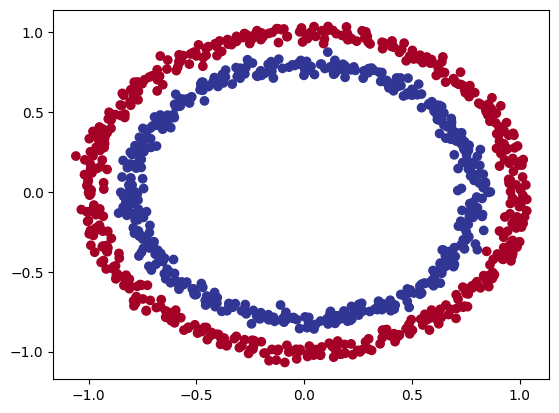

In [5]:
# Visualise 
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
x_samples = X[0]
y_samples = y[0]
print(f"Values for one sample of X: {x_samples} and one sample of y:{y_samples}")
print(f"Shape for one sample of x: {x_samples.shape} and for y: {y_samples.shape}")

Values for one sample of X: [0.75424625 0.23148074] and one sample of y:1
Shape for one sample of x: (2,) and for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch 
torch.__version__

'2.2.2+cu121'

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into training and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Build model to classify blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create training and test loop

In [13]:
# Import libraries
import torch 
from torch import nn 
# Make device agnoistic code 
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

Create a model:

1. Subclassing`nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of model
4. Instantiate an instance of model class and send it to the target device

In [14]:
# 1. .Construct a model that subclasses nn.Module 
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling shapes of out data 
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
# 4. Instantiate an instance of our model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
# Replicate the model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0783, -0.6774],
                      [-0.2039,  0.6972],
                      [ 0.2704,  0.3926],
                      [ 0.5543,  0.4021],
                      [-0.5891, -0.6573]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4338,  0.5037,  0.2626, -0.1518, -0.2763], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1316, -0.0270, -0.1992,  0.0506, -0.3146]], device='cuda:0')),
             ('1.bias', tensor([0.0175], device='cuda:0'))])

In [18]:
# Make prediction 
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shpae: {X_test.shape}")
print(f"\n First 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\n First 10 labels: \n{y_test[:10]}")

length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shpae: torch.Size([200, 2])

 First 10 predictions: 
tensor([[-0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]], device='cuda:0')

 First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
# Setup the loss functino
# loss_fn = nn.BCELoss() # this required input to have gone throught the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # This have the sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [20]:
# Calculate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

### 3. Train model

We need to build training loop with following steps:
1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (gradient descent)

### 3.1 Going from raw logists -> prediction probabilites -> prediction labels

Our model outputs are going to be **logists**.

We can convert these **logists** to prediction probabilites by passing them to some kind of activation function (e.g. sigmoid for binary classification crossentropy and softmax for multiclass classification).

Then we can convert our model prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [21]:
# View the first 5 outputs of the forward pass on the test data 
model_0.eval()
with torch.inference_mode():
    y_logists = model_0(X_test.to(device))[:5]
y_logists

tensor([[-0.0640],
        [ 0.0158],
        [-0.1624],
        [-0.0366],
        [ 0.0138]], device='cuda:0')

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [23]:
# Use the sigmoid activation function on model logists to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logists)
y_pred_probs

tensor([[0.4840],
        [0.5040],
        [0.4595],
        [0.4908],
        [0.5035]], device='cuda:0')

In [24]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logists -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# Check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
# Put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Build training and evaluation loop 
for epoch in range(epochs):
    ### Training 
    model_0.train()
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logists))
    # 2. Calculate the loss 
    # loss = loss_fn(torch.sigmoid(y_logists), y_train) ## nn.BCELoss expect prediction probabilities as input 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5 Optimizer step 
    optimizer.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
     # Print out whats happening
    if epoch % 10 == 0:
        print(f"Epochs: {epoch} | Loss:{loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epochs: 0 | Loss:0.69427, Acc: 40000.00% | Test loss: 0.69753, Test acc: 50.00%
Epochs: 10 | Loss:0.69401, Acc: 40000.00% | Test loss: 0.69712, Test acc: 49.50%
Epochs: 20 | Loss:0.69383, Acc: 40000.00% | Test loss: 0.69676, Test acc: 49.50%
Epochs: 30 | Loss:0.69370, Acc: 40000.00% | Test loss: 0.69645, Test acc: 49.00%
Epochs: 40 | Loss:0.69359, Acc: 40000.00% | Test loss: 0.69618, Test acc: 48.50%
Epochs: 50 | Loss:0.69350, Acc: 40000.00% | Test loss: 0.69594, Test acc: 48.50%
Epochs: 60 | Loss:0.69343, Acc: 40000.00% | Test loss: 0.69574, Test acc: 48.50%
Epochs: 70 | Loss:0.69337, Acc: 40000.00% | Test loss: 0.69557, Test acc: 49.00%
Epochs: 80 | Loss:0.69332, Acc: 40000.00% | Test loss: 0.69543, Test acc: 48.50%
Epochs: 90 | Loss:0.69328, Acc: 40000.00% | Test loss: 0.69531, Test acc: 48.00%


## 4. Make predictions and evaluate the model

To do so, we're going to import a function called `plot_decision_boundary()`

In [26]:
import requests
from pathlib import Path
# Download helper function from the Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download")
else: 
    print("Download helper_function.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py","wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exist, skipping download


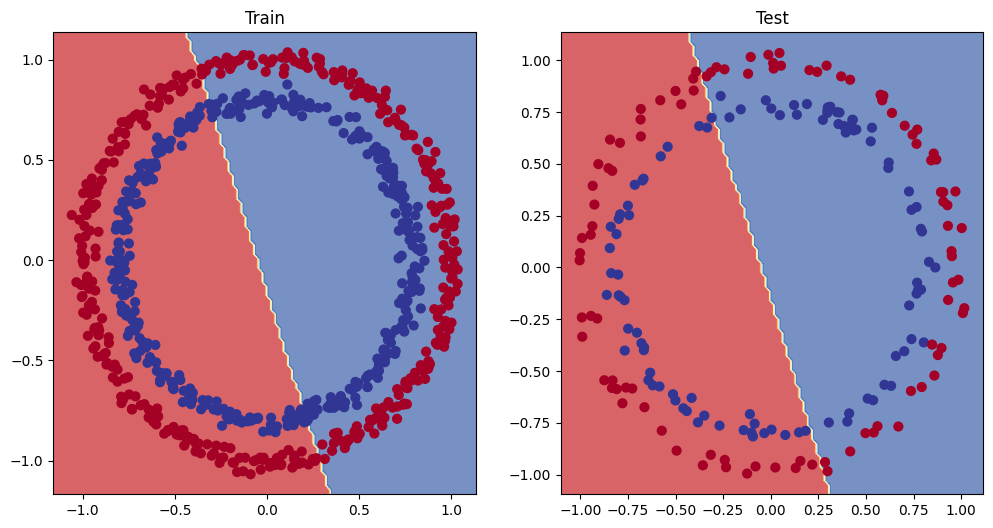

In [27]:
# Plot decision boundary of model 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model prespective)

* Add more layers - give the model more chances to learnabout patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions 
* Change the learning rate
* Change the loss function

These options are all from a model's perspective as they deal with the model

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3 
* Increase the number of epochs: 100 -> 1000

In [28]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) 
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [31]:
# Create a loss function 
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Train for longer 
epochs = 1000 
# Put data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
### Training 
for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step 
    optimizer.step()
    ### Testing
    model_1.train()
    with torch.inference_mode():
        # 1. Forward pass 
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test,test_pred)
     # Print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


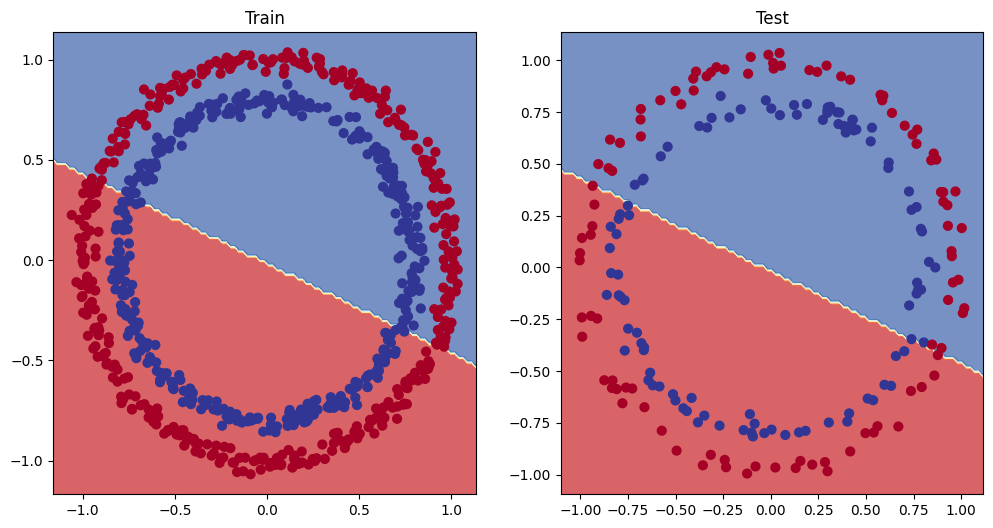

In [33]:
# Plot decision boundary of model 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model fit straight line

In [34]:
# Create some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
# create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias 
len(X_regression), X_regression[:5], y_regression[:5]

(100,
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [35]:
# Create train and test split 
train_split = int(0.8*len(X_regression))
X_train_regression , y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

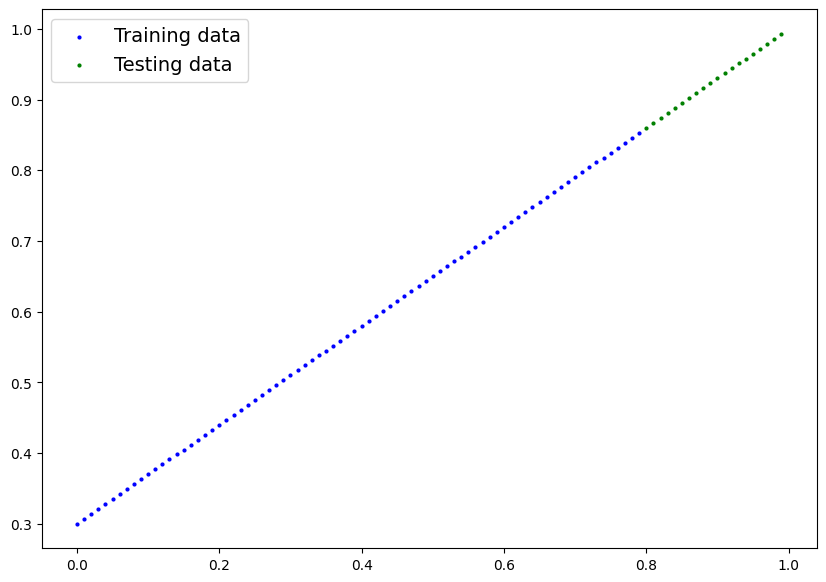

In [36]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjust `model_1` to fit a straight line

In [37]:
# Same architecture as model_1 (using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer 
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.001)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.94965
Epoch: 100 | Loss: 0.40272 | Test loss: 0.54029
Epoch: 200 | Loss: 0.05876 | Test loss: 0.13480
Epoch: 300 | Loss: 0.01461 | Test loss: 0.03342
Epoch: 400 | Loss: 0.00308 | Test loss: 0.00008
Epoch: 500 | Loss: 0.00309 | Test loss: 0.00012
Epoch: 600 | Loss: 0.00309 | Test loss: 0.00018
Epoch: 700 | Loss: 0.00299 | Test loss: 0.00011
Epoch: 800 | Loss: 0.00299 | Test loss: 0.00016
Epoch: 900 | Loss: 0.00289 | Test loss: 0.00011


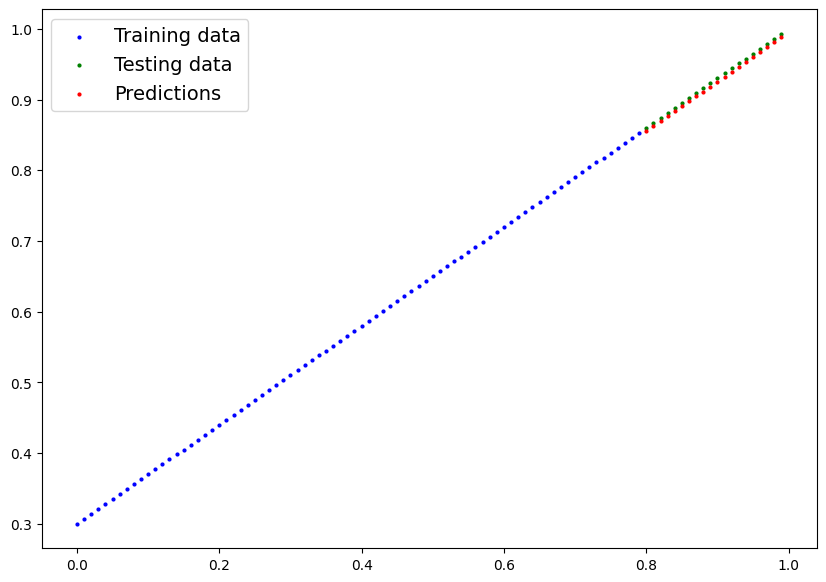

In [40]:
# Evaluation mode
model_2.eval()
# Make prediction
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds.cpu())

## 6. The missing piece: non-linearity


### 6.1 Recreating non-linear data (red and blue circle)

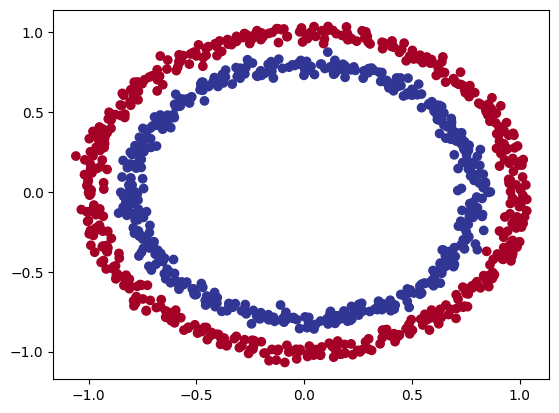

In [41]:
# make and plot data 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles
n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [42]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [43]:
# Convert data into tensors and then to train and test splits
import torch 
from sklearn.model_selection import train_test_split
# Turn data into tensors 
X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).to(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [44]:
# Build model with non-linear activation function 
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Setup the loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training model with non-linearity

In [46]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Put all data on target device 
X_train , y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
# Set the epochs 
epochs = 1000
for epoch in range(epochs):
    # Training
    model_3.train()
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probability -> prediction labels
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Step the optimizer
    optimizer.step()
    # Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
    # Print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss:{loss:.4f}, Acc: {acc:.2f}% | Test Loss:{test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss:0.6929, Acc: 50.00% | Test Loss:0.6932, Test Acc: 50.00%
Epoch: 100 | Loss:0.6912, Acc: 52.88% | Test Loss:0.6910, Test Acc: 52.50%
Epoch: 200 | Loss:0.6898, Acc: 53.37% | Test Loss:0.6894, Test Acc: 55.00%
Epoch: 300 | Loss:0.6879, Acc: 53.00% | Test Loss:0.6872, Test Acc: 56.00%
Epoch: 400 | Loss:0.6852, Acc: 52.75% | Test Loss:0.6841, Test Acc: 56.50%
Epoch: 500 | Loss:0.6810, Acc: 52.75% | Test Loss:0.6794, Test Acc: 56.50%
Epoch: 600 | Loss:0.6751, Acc: 54.50% | Test Loss:0.6729, Test Acc: 56.00%
Epoch: 700 | Loss:0.6666, Acc: 58.38% | Test Loss:0.6632, Test Acc: 59.00%
Epoch: 800 | Loss:0.6516, Acc: 64.00% | Test Loss:0.6476, Test Acc: 67.50%
Epoch: 900 | Loss:0.6236, Acc: 74.00% | Test Loss:0.6215, Test Acc: 79.00%


In [47]:
# Make predictions 
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

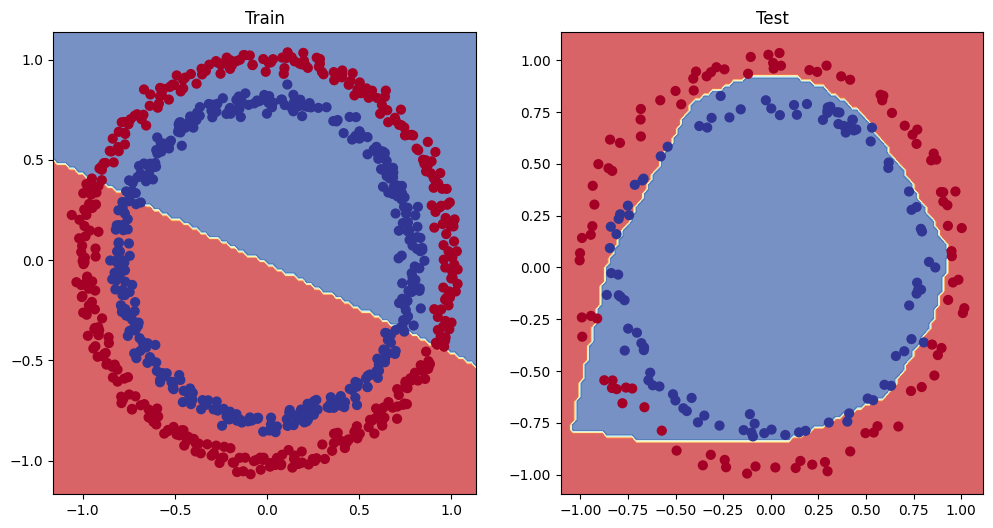

In [48]:
# Plot decision boundaries 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


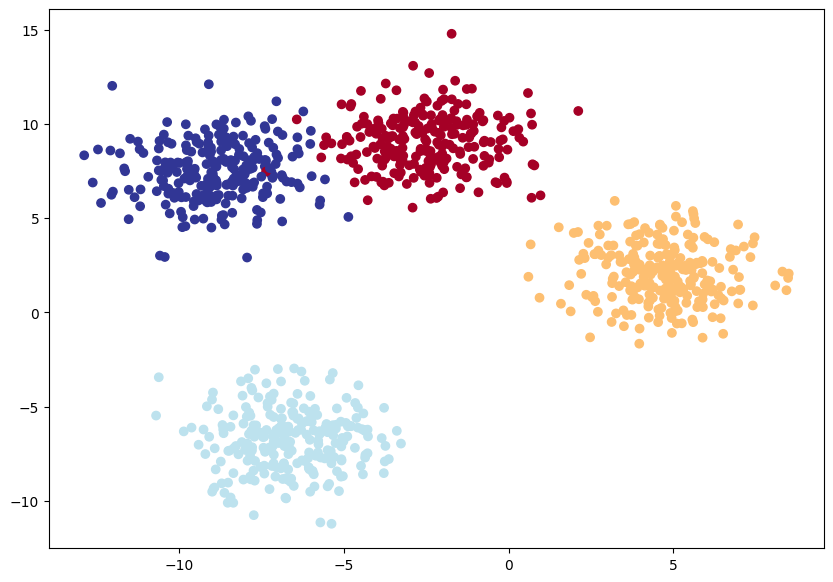

In [74]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [75]:
# Create device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [76]:
# Build a multi-class classification model 
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multi-class classification model
        Args: 
        input_features (int): Number of input features to the model 
        output_features (int): Number of output features (number of output classes)
        hidden_units (int): Number of hidden units between layers, default 8
        """        
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [77]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

### 8.3 Create a loss function and an optimizer for a multi-class classification model 

In [78]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer function for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
Logits (raw output of the model) -> Pred prob (use `torch.softmax()`)-> Pred labels (use the `torch.argmax()`)

In [79]:
#  Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [80]:
# Convert our model's logits output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [81]:
# Convert our model's preediction probabilities  to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Create a training and testing  loop for a multi-class PyTorch model

In [82]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [84]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.06362, Acc: 54.62% | Test Loss: 1.00386, Test Acc: 55.00%
Epoch: 10 | Loss: 0.62096, Acc: 97.25% | Test Loss: 0.63668, Test Acc: 98.00%
Epoch: 20 | Loss: 0.40612, Acc: 98.75% | Test Loss: 0.41038, Test Acc: 100.00%
Epoch: 30 | Loss: 0.23616, Acc: 99.12% | Test Loss: 0.22684, Test Acc: 99.50%
Epoch: 40 | Loss: 0.10442, Acc: 99.25% | Test Loss: 0.09487, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06402, Acc: 99.25% | Test Loss: 0.05627, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04968, Acc: 99.25% | Test Loss: 0.04191, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04243, Acc: 99.25% | Test Loss: 0.03429, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03799, Acc: 99.25% | Test Loss: 0.02949, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03501, Acc: 99.25% | Test Loss: 0.02637, Test Acc: 99.50%


In [85]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6257,  6.0063, -7.6488, -8.4666],
        [-2.1813, -6.3889, -3.7303,  3.1376],
        [-3.4241, -3.9088,  3.1701, -2.6211],
        [-1.1539,  4.2110, -3.8565, -4.8926],
        [ 3.7713, -1.3379, -9.1623, -6.9665],
        [-2.8284, -7.5936, -4.3072,  3.8118],
        [-3.0427, -3.3442,  2.8070, -2.1454],
        [ 3.3902, -4.0445, -6.9149, -3.5610],
        [-4.3793, -5.0066,  3.8291, -3.3930],
        [ 3.5159, -3.0320, -7.5575, -4.7203]], device='cuda:0')

In [86]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


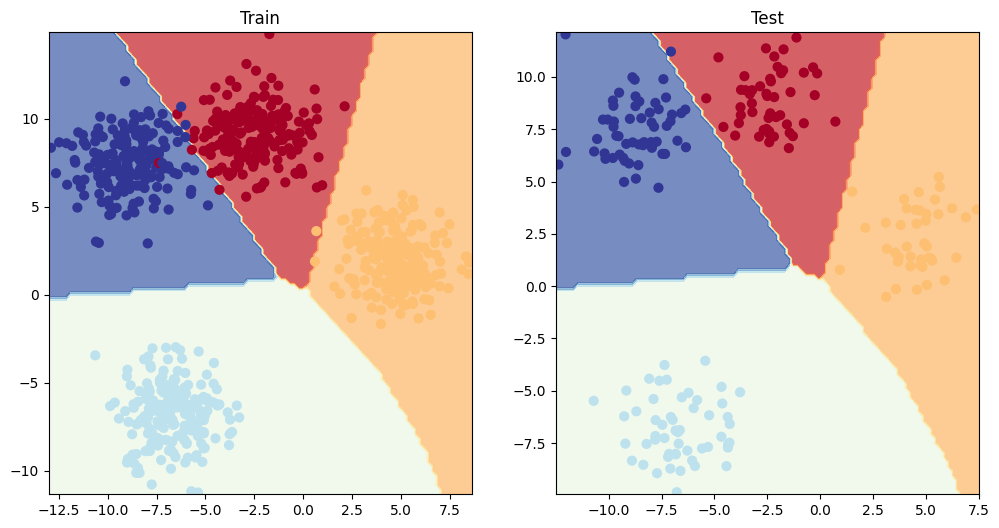

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)